# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [70]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [71]:
# Load the training and test datasets
full_train_data = CIFAR10(root='./data', train=True, download=True)
test_data = CIFAR10(root='./data', train=False, download=True)

# Split the training set into a new training set and a validation set
train_size = int(0.8 * len(full_train_data))  # 80% for training
valid_size = len(full_train_data) - train_size  # 20% for validation
train_data, valid_data = torch.utils.data.random_split(full_train_data, [train_size, valid_size])

Files already downloaded and verified
Files already downloaded and verified


In [104]:
# Define transforms
train_data_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding to augment data
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

common_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply the transforms to the data
train_data.dataset.transform = train_data_transforms
valid_data.dataset.transform = common_transforms
test_data.transform = common_transforms

In [105]:
# Define the dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [106]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2042704].


truck


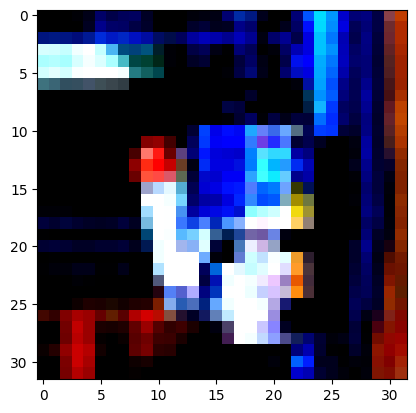

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


frog


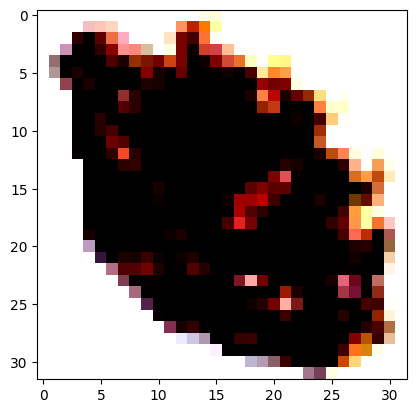

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.1632845].


car


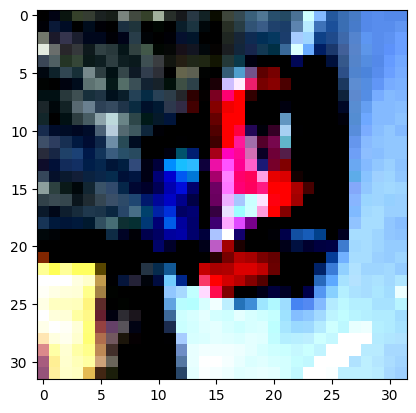

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.3088455].


horse


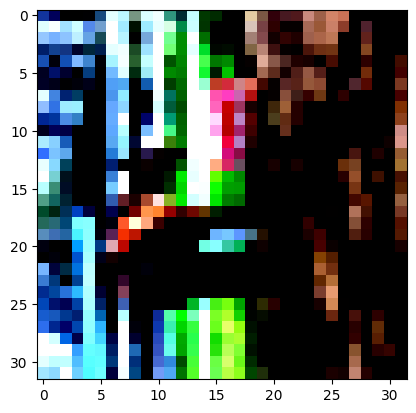

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


dog


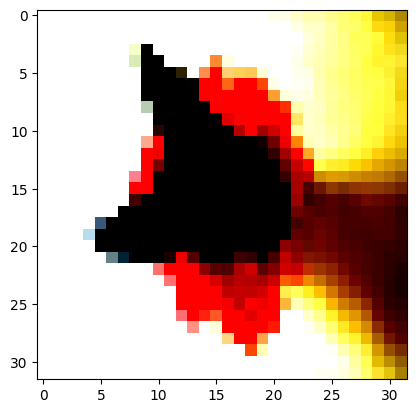

In [107]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [108]:
# Move model to GPU if available and print model architecture
device = torch.device("cuda" if torch.cuda.is_available() 
                          else "mps" if torch.backends.mps.is_available()
                          else "cpu")
print(f"Device: {device}")

Device: mps


In [109]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [112]:
## Instantiate the model (Note: Loss functions defined in model info.) ##
model = Net().to(device)

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [117]:
# Define the parameters for training
epochs = 25
validate_every = 250
accumulation_steps = 4 # Update the weights after 4 iterations
steps = 0
running_loss = 0

# Run the training loop
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

train_losses, valid_losses, accuracies = [], [], []

for e in range(epochs):
    model.train()
    optimizer.zero_grad()  # Zero the gradients at the start of the epoch
    
    for i, (images, labels) in enumerate(train_loader):
        steps += 1
        images, labels = images.to(device), labels.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps  # Normalize the loss by accumulation steps

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        # Perform optimizer step after accumulation_steps iterations
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()  # Reset gradients only after optimizer step

        running_loss += loss.item() * accumulation_steps  # Multiply by accumulation steps to get the total loss

        # Validation check
        if steps % validate_every == 0:
            model.eval()  # Set model to evaluation mode
            valid_loss = 0
            accuracy = 0
            
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    log_ps = model(images)
                    valid_loss += criterion(log_ps, labels).item()
                    
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            train_losses.append(running_loss / len(train_loader))
            valid_losses.append(valid_loss / len(valid_loader))
            accuracies.append(accuracy / len(valid_loader))

            print(f"Epoch: {e+1}/{epochs}.. "
                  f"Training Loss: {running_loss / validate_every:.3f},  "
                  f"Validation Loss: {valid_loss / len(valid_loader):.3f},  "
                  f"Validation Accuracy: {accuracy / len(valid_loader):.3f}")
            
            running_loss = 0  # Reset running loss after validation
            model.train()
            # Step the scheduler based on validation loss
            scheduler.step(valid_loss / len(valid_loader))

/var/folders/mz/1c03knr10fvcbp5gmbsxs8h80000gn/T/ipykernel_86817/2028800766.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Epoch: 1/25.. Training Loss: 0.956,  Validation Loss: 1.064,  Validation Accuracy: 0.756
Epoch: 1/25.. Training Loss: 0.955,  Validation Loss: 1.072,  Validation Accuracy: 0.754
Epoch: 2/25.. Training Loss: 0.937,  Validation Loss: 1.052,  Validation Accuracy: 0.765
Epoch: 2/25.. Training Loss: 0.925,  Validation Loss: 1.070,  Validation Accuracy: 0.759
Epoch: 2/25.. Training Loss: 0.926,  Validation Loss: 1.043,  Validation Accuracy: 0.768
Epoch: 3/25.. Training Loss: 0.889,  Validation Loss: 1.044,  Validation Accuracy: 0.766
Epoch: 3/25.. Training Loss: 0.901,  Validation Loss: 1.058,  Validation Accuracy: 0.763
Epoch: 4/25.. Training Loss: 0.884,  Validation Loss: 1.057,  Validation Accuracy: 0.767
Epoch: 4/25.. Training Loss: 0.863,  Validation Loss: 1.033,  Validation Accuracy: 0.773
Epoch: 4/25.. Training Loss: 0.879,  Validation Loss: 1.043,  Validation Accuracy: 0.767
Epoch: 5/25.. Training Loss: 0.835,  Validation Loss: 1.040,  Validation Accuracy: 0.774
Epoch: 5/25.. Trainin

Plot the training loss (and validation loss/accuracy, if recorded).

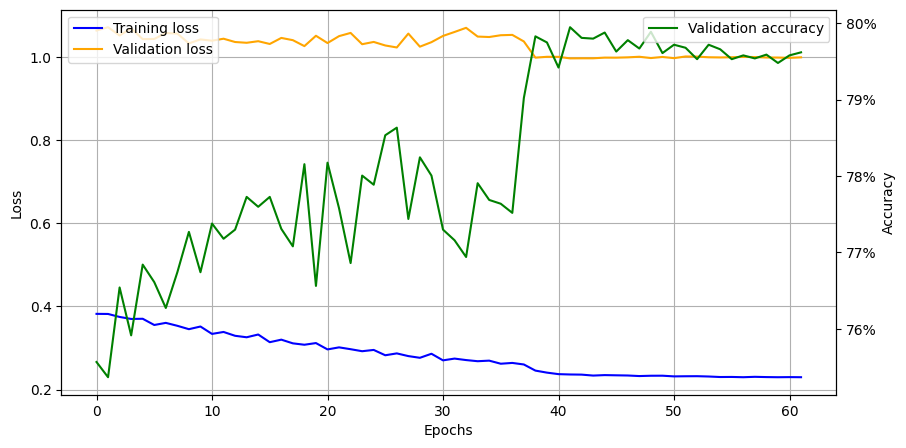

In [120]:
from matplotlib.ticker import FuncFormatter

# Plot the training loss, validation loss, and accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

def to_percent(y, position):
    return f'{y * 100:.0f}%'

# Plot training and validation losses on the left y-axis
ax1.plot(train_losses, label='Training loss', color='blue')
ax1.plot(valid_losses, label='Validation loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax1.grid()

# Create a second y-axis for validation accuracy
ax2 = ax1.twinx()
ax2.plot(accuracies, label='Validation accuracy', color='green')
ax2.set_ylabel('Accuracy')
ax2.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax2.legend(loc='upper right')

plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [119]:
# Test the network on the test data

model.eval()
test_loss = 0
accuracy = 0

# Disable gradient calculation for testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        log_ps = model(inputs)
        test_loss += criterion(log_ps, labels).item()
        
        # Calculate accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        

print(f"Test Loss: {test_loss / len(test_loader):.3f}.. "
    f"Test Accuracy: {accuracy / len(test_loader) * 100:.2f}%")

Test Loss: 1.014.. Test Accuracy: 79.13%


## Saving your model
Using `torch.save`, save your model for future loading.

In [116]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

With a model accuracy of 79.13%, our model is comparable to Krizhevsky's 2010 Deep Belief Networks, which achieved 78.9%. However, it falls short of more recent benchmarks such as Maxout Networks (90.6%), Wide Residual Networks (96.0%), and GPipe (99.0%). If maximizing accuracy is critical, it may be worth investing in models like these, but if we can tolerate a slight reduction in performance, our model is sufficient. Additionally, the accuracy of our model can likely be improved by switching to a more powerful architecture, which would bring it closer to the higher-performing models.